In [1]:
# PACS details
domains = ['photo', 'art_painting', 'cartoon', 'sketch']
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse','house', 'person']

# Set parameters

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torchvision.datasets as Datasets
from torchvision import models
from torchvision.datasets import ImageFolder, DatasetFolder

from utils import *
import os

import numpy as np
import matplotlib.pyplot as plt

from model.resnet18_selfreg import resnet18


In [3]:
##############################
# Training Setting
##############################

# Select model to train
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'
save_name = 'SelfReg_official_test'     # save_dir name
                                        # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = 'pacs_official_split' 
number_of_tests = 1
gpu_num = 1
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

is_selfreg = True  # use selfreg?
is_idcl = True # use IDCL?

epochs = 30
batch_size = 128
is_pretrained = True  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'

#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)


In [4]:
device = torch.device("cpu")
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda:{}".format(gpu_num))
print(device)

# save settings
model_settings = {
    "used_model": used_model,
    "dataset": dataset,
    "save_name": save_name,
    "pacs_ver": pacs_ver,
    "number_of_tests": number_of_tests,
    "epochs": epochs,
    "batch_size": batch_size,
    "is_pretrained": is_pretrained,
    "lr": lr,
    "lr_decay_epoch": lr_decay_epoch,
    "lr_decay_gamma": lr_decay_gamma,
    "gpu_num": gpu_num,
}

criterion = nn.CrossEntropyLoss().to(device)

Using CUDA
cuda:1


# Functions

In [5]:

def classic_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
):

    train_set1 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set2 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set3 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=train_tf,
    )

    val_set1 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set2 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set3 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=test_tf,
    )

    train_set = train_set1 + train_set2 + train_set3
    val_set = val_set1 + val_set2 + val_set3
    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )

    if used_model == "vgg16":
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = len(classes)
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = len(classes)
        model.fc.out_features = len(classes)
    elif used_model == "resnet18":
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    settings = {
        "train_loaders": train_loader,
        "val_loaders": val_loader,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader


def IDCL_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
):

    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3

    for i in range(4):
        if check > check_limit:
            break
        if i == test_domain_idx:
            continue

        temp = ImageFolder(
            root=os.path.join("{}/train".format(pacs_ver), domains[i]),
            transform=train_tf,
        )

        temp_val = ImageFolder(
            root=os.path.join("{}/val".format(pacs_ver), domains[i]), transform=test_tf
        )
        if check == 1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val

        if check == 1:
            train_set_stage1 = train_set
            val_set_stage1 = val_set
        elif check == 2:
            train_set_stage2 = train_set
            val_set_stage2 = val_set
        elif check == 3:
            train_set_stage3 = train_set
            val_set_stage3 = val_set

        check += 1

    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    print("stage1 (train,val):", len(train_set_stage1), len(val_set_stage1))
    print("stage2 (train,val):", len(train_set_stage2), len(val_set_stage2))
    print("stage3 (train,val):", len(train_set_stage3), len(val_set_stage3))
    print("test :", len(test_set))

    t_loader1 = DataLoader(
        train_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader1 = DataLoader(
        val_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader2 = DataLoader(
        train_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader2 = DataLoader(
        val_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader3 = DataLoader(
        train_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader3 = DataLoader(
        val_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )

    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=6
    )

    if used_model == "vgg16":
        print("vgg16")
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = 7
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features = 7
    elif used_model == "resnet18":
        model = resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    train_loaders = [t_loader1, t_loader2, t_loader3]
    val_loaders = [v_loader1, v_loader2, v_loader3]

    settings = {
        "train_loaders": train_loaders,
        "val_loaders": val_loaders,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader



# Automation

stage1 (train,val): 1499 171
stage2 (train,val): 3339 379
stage3 (train,val): 5446 616
test : 3929


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 [128/1499 (9%)],	Accuracy: 9.4%,  	 Loss: 3.4277
Epoch: 1 [256/1499 (17%)],	Accuracy: 9.4%,  	 Loss: 3.2075
Epoch: 1 [384/1499 (26%)],	Accuracy: 24.2%,  	 Loss: 2.9372
Epoch: 1 [512/1499 (34%)],	Accuracy: 37.5%,  	 Loss: 2.5882
Epoch: 1 [640/1499 (43%)],	Accuracy: 36.7%,  	 Loss: 2.6332
Epoch: 1 [768/1499 (51%)],	Accuracy: 57.8%,  	 Loss: 2.2303
Epoch: 1 [896/1499 (60%)],	Accuracy: 46.1%,  	 Loss: 2.2320
Epoch: 1 [1024/1499 (68%)],	Accuracy: 60.2%,  	 Loss: 2.1070
Epoch: 1 [1152/1499 (77%)],	Accuracy: 77.3%,  	 Loss: 1.7260
Epoch: 1 [1280/1499 (85%)],	Accuracy: 85.2%,  	 Loss: 1.4426
Epoch: 1 [1408/1499 (94%)],	Accuracy: 90.6%,  	 Loss: 1.1760
Epoch: 1 [1499/1499 (100%)],	Accuracy: 90.1%,  	 Loss: 1.2143
loss_val: 0.7527423799037933 171
acc_val: 160 171
Validation ==================================================
Avg loss (val): 0.0044
Avg acc (val): 0.9357

Epoch: 2 [128/1499 (9%)],	Accuracy: 94.5%,  	 Loss: 1.0053
Epoch: 2 [256/1499 (17%)],	Accuracy: 93.8%,  	 Loss: 0.9160


Epoch: 8 [512/3339 (15%)],	Accuracy: 95.3%,  	 Loss: 0.5806
Epoch: 8 [640/3339 (19%)],	Accuracy: 95.3%,  	 Loss: 0.4947
Epoch: 8 [768/3339 (23%)],	Accuracy: 94.5%,  	 Loss: 0.5162
Epoch: 8 [896/3339 (27%)],	Accuracy: 96.1%,  	 Loss: 0.5768
Epoch: 8 [1024/3339 (31%)],	Accuracy: 96.1%,  	 Loss: 0.5725
Epoch: 8 [1152/3339 (35%)],	Accuracy: 96.1%,  	 Loss: 0.5072
Epoch: 8 [1280/3339 (38%)],	Accuracy: 95.3%,  	 Loss: 0.4586
Epoch: 8 [1408/3339 (42%)],	Accuracy: 93.0%,  	 Loss: 0.5824
Epoch: 8 [1536/3339 (46%)],	Accuracy: 97.7%,  	 Loss: 0.4179
Epoch: 8 [1664/3339 (50%)],	Accuracy: 96.1%,  	 Loss: 0.4768
Epoch: 8 [1792/3339 (54%)],	Accuracy: 94.5%,  	 Loss: 0.6661
Epoch: 8 [1920/3339 (58%)],	Accuracy: 96.1%,  	 Loss: 0.4735
Epoch: 8 [2048/3339 (61%)],	Accuracy: 93.0%,  	 Loss: 0.5217
Epoch: 8 [2176/3339 (65%)],	Accuracy: 96.9%,  	 Loss: 0.4008
Epoch: 8 [2304/3339 (69%)],	Accuracy: 98.4%,  	 Loss: 0.4477
Epoch: 8 [2432/3339 (73%)],	Accuracy: 95.3%,  	 Loss: 0.4420
Epoch: 8 [2560/3339 (77%)],	

Epoch: 12 [512/5446 (9%)],	Accuracy: 94.5%,  	 Loss: 0.6204
Epoch: 12 [640/5446 (12%)],	Accuracy: 95.3%,  	 Loss: 0.6492
Epoch: 12 [768/5446 (14%)],	Accuracy: 93.8%,  	 Loss: 0.5862
Epoch: 12 [896/5446 (16%)],	Accuracy: 91.4%,  	 Loss: 0.7624
Epoch: 12 [1024/5446 (19%)],	Accuracy: 93.8%,  	 Loss: 0.7025
Epoch: 12 [1152/5446 (21%)],	Accuracy: 96.9%,  	 Loss: 0.4881
Epoch: 12 [1280/5446 (24%)],	Accuracy: 95.3%,  	 Loss: 0.5873
Epoch: 12 [1408/5446 (26%)],	Accuracy: 93.8%,  	 Loss: 0.7397
Epoch: 12 [1536/5446 (28%)],	Accuracy: 92.2%,  	 Loss: 0.7800
Epoch: 12 [1664/5446 (31%)],	Accuracy: 96.1%,  	 Loss: 0.5298
Epoch: 12 [1792/5446 (33%)],	Accuracy: 95.3%,  	 Loss: 0.4646
Epoch: 12 [1920/5446 (35%)],	Accuracy: 96.1%,  	 Loss: 0.5923
Epoch: 12 [2048/5446 (38%)],	Accuracy: 93.8%,  	 Loss: 0.5852
Epoch: 12 [2176/5446 (40%)],	Accuracy: 95.3%,  	 Loss: 0.5916
Epoch: 12 [2304/5446 (42%)],	Accuracy: 96.1%,  	 Loss: 0.4959
Epoch: 12 [2432/5446 (45%)],	Accuracy: 97.7%,  	 Loss: 0.4676
Epoch: 12 [25

Epoch: 15 [128/5446 (2%)],	Accuracy: 98.4%,  	 Loss: 0.2695
Epoch: 15 [256/5446 (5%)],	Accuracy: 97.7%,  	 Loss: 0.3358
Epoch: 15 [384/5446 (7%)],	Accuracy: 95.3%,  	 Loss: 0.3523
Epoch: 15 [512/5446 (9%)],	Accuracy: 99.2%,  	 Loss: 0.1633
Epoch: 15 [640/5446 (12%)],	Accuracy: 96.9%,  	 Loss: 0.3370
Epoch: 15 [768/5446 (14%)],	Accuracy: 99.2%,  	 Loss: 0.2152
Epoch: 15 [896/5446 (16%)],	Accuracy: 96.9%,  	 Loss: 0.3031
Epoch: 15 [1024/5446 (19%)],	Accuracy: 97.7%,  	 Loss: 0.2636
Epoch: 15 [1152/5446 (21%)],	Accuracy: 99.2%,  	 Loss: 0.1691
Epoch: 15 [1280/5446 (24%)],	Accuracy: 98.4%,  	 Loss: 0.2754
Epoch: 15 [1408/5446 (26%)],	Accuracy: 99.2%,  	 Loss: 0.2121
Epoch: 15 [1536/5446 (28%)],	Accuracy: 97.7%,  	 Loss: 0.2226
Epoch: 15 [1664/5446 (31%)],	Accuracy: 96.9%,  	 Loss: 0.2868
Epoch: 15 [1792/5446 (33%)],	Accuracy: 98.4%,  	 Loss: 0.1908
Epoch: 15 [1920/5446 (35%)],	Accuracy: 96.9%,  	 Loss: 0.3570
Epoch: 15 [2048/5446 (38%)],	Accuracy: 96.9%,  	 Loss: 0.4037
Epoch: 15 [2176/544

loss_val: 0.8594867289066315 616
acc_val: 584 616
Validation ==================================================
Avg loss (val): 0.0014
Avg acc (val): 0.9481

Epoch: 18 [128/5446 (2%)],	Accuracy: 98.4%,  	 Loss: 0.2391
Epoch: 18 [256/5446 (5%)],	Accuracy: 99.2%,  	 Loss: 0.1011
Epoch: 18 [384/5446 (7%)],	Accuracy: 99.2%,  	 Loss: 0.1420
Epoch: 18 [512/5446 (9%)],	Accuracy: 100.0%,  	 Loss: 0.0813
Epoch: 18 [640/5446 (12%)],	Accuracy: 98.4%,  	 Loss: 0.1276
Epoch: 18 [768/5446 (14%)],	Accuracy: 100.0%,  	 Loss: 0.1075
Epoch: 18 [896/5446 (16%)],	Accuracy: 97.7%,  	 Loss: 0.1867
Epoch: 18 [1024/5446 (19%)],	Accuracy: 98.4%,  	 Loss: 0.1402
Epoch: 18 [1152/5446 (21%)],	Accuracy: 98.4%,  	 Loss: 0.1284
Epoch: 18 [1280/5446 (24%)],	Accuracy: 99.2%,  	 Loss: 0.1135
Epoch: 18 [1408/5446 (26%)],	Accuracy: 99.2%,  	 Loss: 0.0892
Epoch: 18 [1536/5446 (28%)],	Accuracy: 99.2%,  	 Loss: 0.1093
Epoch: 18 [1664/5446 (31%)],	Accuracy: 99.2%,  	 Loss: 0.1188
Epoch: 18 [1792/5446 (33%)],	Accuracy: 99.2%,

Epoch: 20 [5120/5446 (94%)],	Accuracy: 99.2%,  	 Loss: 0.1123
Epoch: 20 [5248/5446 (96%)],	Accuracy: 100.0%,  	 Loss: 0.0475
Epoch: 20 [5376/5446 (99%)],	Accuracy: 98.4%,  	 Loss: 0.1745
Epoch: 20 [5446/5446 (100%)],	Accuracy: 100.0%,  	 Loss: 0.0381
loss_val: 0.7625980824232101 616
acc_val: 589 616
Validation ==================================================
Avg loss (val): 0.0012
Avg acc (val): 0.9562

Epoch: 21 [128/5446 (2%)],	Accuracy: 99.2%,  	 Loss: 0.0891
Epoch: 21 [256/5446 (5%)],	Accuracy: 100.0%,  	 Loss: 0.0460
Epoch: 21 [384/5446 (7%)],	Accuracy: 99.2%,  	 Loss: 0.1308
Epoch: 21 [512/5446 (9%)],	Accuracy: 100.0%,  	 Loss: 0.0458
Epoch: 21 [640/5446 (12%)],	Accuracy: 100.0%,  	 Loss: 0.0734
Epoch: 21 [768/5446 (14%)],	Accuracy: 99.2%,  	 Loss: 0.0746
Epoch: 21 [896/5446 (16%)],	Accuracy: 99.2%,  	 Loss: 0.0525
Epoch: 21 [1024/5446 (19%)],	Accuracy: 100.0%,  	 Loss: 0.0735
Epoch: 21 [1152/5446 (21%)],	Accuracy: 99.2%,  	 Loss: 0.0876
Epoch: 21 [1280/5446 (24%)],	Accuracy: 1

Epoch: 23 [4480/5446 (82%)],	Accuracy: 99.2%,  	 Loss: 0.0631
Epoch: 23 [4608/5446 (85%)],	Accuracy: 98.4%,  	 Loss: 0.1219
Epoch: 23 [4736/5446 (87%)],	Accuracy: 100.0%,  	 Loss: 0.0732
Epoch: 23 [4864/5446 (89%)],	Accuracy: 99.2%,  	 Loss: 0.0995
Epoch: 23 [4992/5446 (92%)],	Accuracy: 99.2%,  	 Loss: 0.0647
Epoch: 23 [5120/5446 (94%)],	Accuracy: 100.0%,  	 Loss: 0.0343
Epoch: 23 [5248/5446 (96%)],	Accuracy: 99.2%,  	 Loss: 0.0875
Epoch: 23 [5376/5446 (99%)],	Accuracy: 99.2%,  	 Loss: 0.1476
Epoch: 23 [5446/5446 (100%)],	Accuracy: 100.0%,  	 Loss: 0.1204
loss_val: 0.7434348613023758 616
acc_val: 587 616
Validation ==================================================
Avg loss (val): 0.0012
Avg acc (val): 0.9529

Epoch: 24 [128/5446 (2%)],	Accuracy: 100.0%,  	 Loss: 0.0316
Epoch: 24 [256/5446 (5%)],	Accuracy: 100.0%,  	 Loss: 0.0542
Epoch: 24 [384/5446 (7%)],	Accuracy: 100.0%,  	 Loss: 0.0381
Epoch: 24 [512/5446 (9%)],	Accuracy: 100.0%,  	 Loss: 0.0249
Epoch: 24 [640/5446 (12%)],	Accuracy

Epoch: 26 [3840/5446 (71%)],	Accuracy: 100.0%,  	 Loss: 0.0333
Epoch: 26 [3968/5446 (73%)],	Accuracy: 99.2%,  	 Loss: 0.1099
Epoch: 26 [4096/5446 (75%)],	Accuracy: 99.2%,  	 Loss: 0.1361
Epoch: 26 [4224/5446 (78%)],	Accuracy: 99.2%,  	 Loss: 0.0761
Epoch: 26 [4352/5446 (80%)],	Accuracy: 99.2%,  	 Loss: 0.1167
Epoch: 26 [4480/5446 (82%)],	Accuracy: 100.0%,  	 Loss: 0.0567
Epoch: 26 [4608/5446 (85%)],	Accuracy: 100.0%,  	 Loss: 0.0285
Epoch: 26 [4736/5446 (87%)],	Accuracy: 100.0%,  	 Loss: 0.0434
Epoch: 26 [4864/5446 (89%)],	Accuracy: 100.0%,  	 Loss: 0.0361
Epoch: 26 [4992/5446 (92%)],	Accuracy: 100.0%,  	 Loss: 0.0384
Epoch: 26 [5120/5446 (94%)],	Accuracy: 100.0%,  	 Loss: 0.0288
Epoch: 26 [5248/5446 (96%)],	Accuracy: 100.0%,  	 Loss: 0.0363
Epoch: 26 [5376/5446 (99%)],	Accuracy: 100.0%,  	 Loss: 0.0302
Epoch: 26 [5446/5446 (100%)],	Accuracy: 100.0%,  	 Loss: 0.0198
loss_val: 0.6847572922706604 616
acc_val: 586 616
Validation ==================================================
Avg loss 

Epoch: 29 [3200/5446 (59%)],	Accuracy: 100.0%,  	 Loss: 0.0378
Epoch: 29 [3328/5446 (61%)],	Accuracy: 99.2%,  	 Loss: 0.0707
Epoch: 29 [3456/5446 (63%)],	Accuracy: 100.0%,  	 Loss: 0.0248
Epoch: 29 [3584/5446 (66%)],	Accuracy: 99.2%,  	 Loss: 0.0478
Epoch: 29 [3712/5446 (68%)],	Accuracy: 100.0%,  	 Loss: 0.0377
Epoch: 29 [3840/5446 (71%)],	Accuracy: 100.0%,  	 Loss: 0.0293
Epoch: 29 [3968/5446 (73%)],	Accuracy: 100.0%,  	 Loss: 0.0191
Epoch: 29 [4096/5446 (75%)],	Accuracy: 100.0%,  	 Loss: 0.0383
Epoch: 29 [4224/5446 (78%)],	Accuracy: 100.0%,  	 Loss: 0.0260
Epoch: 29 [4352/5446 (80%)],	Accuracy: 100.0%,  	 Loss: 0.0247
Epoch: 29 [4480/5446 (82%)],	Accuracy: 100.0%,  	 Loss: 0.0395
Epoch: 29 [4608/5446 (85%)],	Accuracy: 100.0%,  	 Loss: 0.0187
Epoch: 29 [4736/5446 (87%)],	Accuracy: 100.0%,  	 Loss: 0.0253
Epoch: 29 [4864/5446 (89%)],	Accuracy: 100.0%,  	 Loss: 0.0328
Epoch: 29 [4992/5446 (92%)],	Accuracy: 99.2%,  	 Loss: 0.0672
Epoch: 29 [5120/5446 (94%)],	Accuracy: 100.0%,  	 Loss: 0.

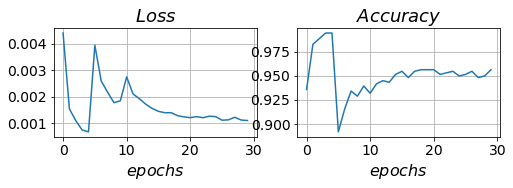

stage1 (train,val): 1499 171
stage2 (train,val): 3339 379
stage3 (train,val): 6870 777
test : 2344
Epoch: 1 [128/1499 (9%)],	Accuracy: 14.1%,  	 Loss: 2.9377
Epoch: 1 [256/1499 (17%)],	Accuracy: 21.9%,  	 Loss: 2.9139
Epoch: 1 [384/1499 (26%)],	Accuracy: 36.7%,  	 Loss: 2.7405
Epoch: 1 [512/1499 (34%)],	Accuracy: 51.6%,  	 Loss: 2.4277
Epoch: 1 [640/1499 (43%)],	Accuracy: 48.4%,  	 Loss: 2.2451
Epoch: 1 [768/1499 (51%)],	Accuracy: 56.2%,  	 Loss: 2.2093
Epoch: 1 [896/1499 (60%)],	Accuracy: 64.1%,  	 Loss: 2.0783
Epoch: 1 [1024/1499 (68%)],	Accuracy: 73.4%,  	 Loss: 1.8943
Epoch: 1 [1152/1499 (77%)],	Accuracy: 76.6%,  	 Loss: 1.5940
Epoch: 1 [1280/1499 (85%)],	Accuracy: 82.0%,  	 Loss: 1.4682
Epoch: 1 [1408/1499 (94%)],	Accuracy: 87.5%,  	 Loss: 1.3007
Epoch: 1 [1499/1499 (100%)],	Accuracy: 96.7%,  	 Loss: 0.8525


Process Process-381:
Traceback (most recent call last):
Exception ignored in: <function _releaseLock at 0x7f05595584c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 299, in _bootstrap
    util._close_stdin()
  File "/opt/conda/lib/python3.8/multiprocessing/util.py", line 422, in _close_stdin
    sys.stdin = open(fd, closefd=False)
  File "/opt/conda/lib/python3.8/_bootlocale.py", line 33, in getpreferredencoding
    def getpreferredencoding(do_setlocale=True):
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 1397312, 1397352, 1397392) exited unexpectedly

In [6]:
save_model_setting(model_settings, used_model, domains, dataset, save_name)
set_train = IDCL_setting if is_idcl else classic_setting
temp_dict = {
    "device": device,
    "epochs": epochs,
    "criterion": criterion,
    "is_selfreg": is_selfreg,
    "is_idcl": is_idcl,
}

for i in range(1, number_of_tests + 1):
    try_check = i

    for test_idx in [3, 2, 1, 0]:

        ##########################
        ####   Setting Train  ####
        ##########################

        model_sets = [
            test_idx,
            domains,
            batch_size,
            is_pretrained,
            train_tf,
            test_tf,
            used_model,
            pacs_ver,
            used_optimizer,
        ]
        train_settings, test_loader = set_train(*model_sets)
        train_settings.update(temp_dict)

        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)

        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print("Error : Creating directory. " + save_dir)

        ##########################
        ####     Training     ####
        ##########################

        model, losses, accuracies = train(**train_settings)
        test_accuracy = test(
            device, model, criterion, test_loader, used_model, save_dir, try_check
        )

        total_result_text_path = os.path.join(save_dir, "test_total_result.txt")
        with open(total_result_text_path, "a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy) + "\n")

        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
#         save_model(model, used_model, save_dir, is_pretrained, try_check)
        